In [1]:
import pandas as pd
import seaborn as sb
import re
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
data = pd.read_csv("../Results/metrics/mapping_stats_newTissues.csv", comment = "#", header = 0, index_col=False)

data['chrM'] = ["chrM" if ele.endswith("chrM") else "All" for ele in data["File"]]
data['Name'] = data['File'].str.extract(r'([a-zA-Z]+_[a-zA-Z]+_[a-zA-Z]+)(?:_chrM)?', expand = True)

sub_data = pd.melt(data[["Name","Mapped(QC passed)", "Duplicates(QC passed)", "chrM"]], id_vars = ['chrM', 'Name'])

all_read = sub_data[sub_data['chrM'] == "All"]
all_read = all_read.set_index(['chrM', 'Name', 'variable'])
chrM_read = sub_data[sub_data['chrM'] == "chrM"]
chrM_read = chrM_read.set_index(['chrM', 'Name', 'variable'])

sub_data = all_read.merge(chrM_read, on = ['Name', 'variable'], suffixes = ('_All', '_chrM'), validate = '1:1')
sub_data['ratio'] = sub_data['value_chrM'] / sub_data['value_All']
sub_data = sub_data.reset_index()
sub_data['Tissue'] = sub_data['Name'].str.extract(r'(\w+?)_.+', expand=True)
sub_data['Rep'] = sub_data['Name'].str.extract(r'^\w+?_(\w+?)_\w+', expand=True)
sub_data['Assay'] = sub_data['Name'].str.extract(r'^\w+?_\w+?_(\w+)', expand=True)
sub_data = sub_data.drop('Name', axis = 1)
#sub_data = sub_data.set_index(['Tissue', 'Rep', 'Assay', 'variable']).sort_index()

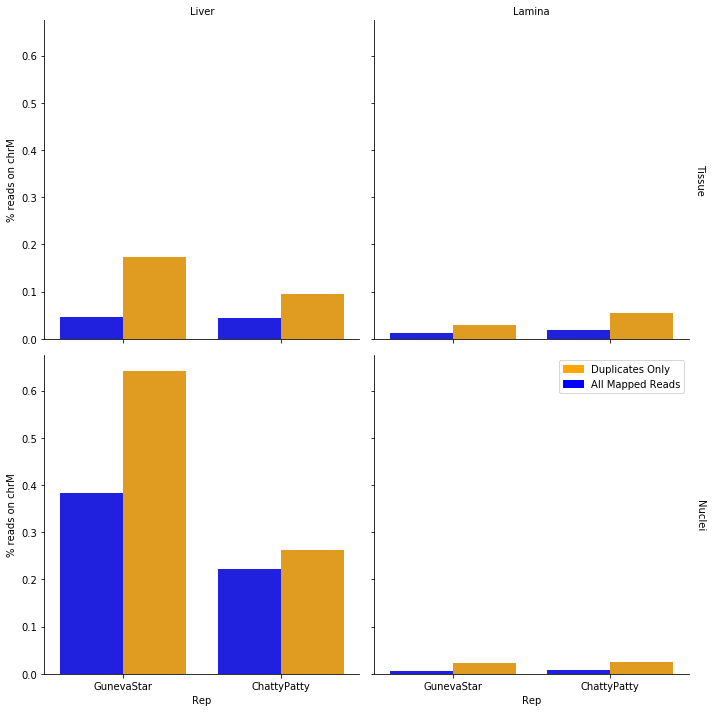

In [6]:
#f, ax = plt.subplots(figsize = (10,10))
grid = sb.FacetGrid(sub_data, col = 'Tissue', row = 'Assay', margin_titles=True, legend_out = True, height = 5)
grid.map(sb.barplot, 'Rep','ratio', 'variable', order = sub_data.Rep.unique(), palette = ['Blue', 'Orange'], hue_order = sub_data.variable.unique())
[plt.setp(ax.texts, text="") for ax in grid.axes.flat]
grid.set_titles(row_template = '{row_name}', col_template = '{col_name}')
name_to_color = {
    'Duplicates Only':   'Orange',
    'All Mapped Reads':   'Blue',
}
grid.set_ylabels('% reads on chrM')
patches = [matplotlib.patches.Patch(color=v, label=k) for k,v in name_to_color.items()]
plt.legend(handles=patches)
#grid.add_legend(title = "Reads")
plt.savefig("chrM.png")

In [7]:
all_reads = sub_data[sub_data['variable'] == 'Mapped(QC passed)'].drop('variable', axis = 1)
dup_reads = sub_data[sub_data['variable'] == 'Duplicates(QC passed)'].drop('variable', axis = 1)

sub_data = dup_reads.merge(all_reads, on = ['Tissue', 'Rep', 'Assay'], suffixes=['_Dup', '_All'])

sub_data['Tissue'] = sub_data['Tissue'].astype('category')
sub_data['Rep'] = sub_data['Rep'].astype('category')
sub_data['Assay'] = sub_data['Assay'].astype('category')

sub_data['dupRate_All'] = sub_data['value_All_Dup'] / sub_data['value_All_All']
sub_data['dupRate_chrM'] = sub_data['value_chrM_Dup'] / sub_data['value_chrM_All']

[Text(0, 0.5, '% Duplicate reads'), Text(0.5, 0, '% reads mapped to chrM')]

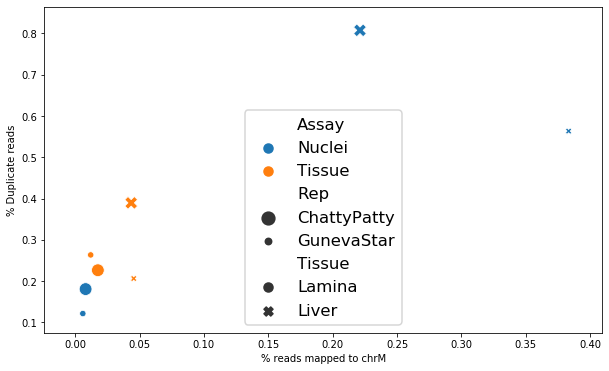

In [8]:
f, ax = plt.subplots(figsize = (10,6))
sb.set_context('talk')
ax = sb.scatterplot(ax = ax, data = sub_data[['Tissue', 'Rep', 'Assay', 'ratio_Dup', 'ratio_All', 'dupRate_All', 'dupRate_chrM']], x = 'ratio_All', y = 'dupRate_All', style = 'Tissue', hue = 'Assay', size = 'Rep', legend = 'full')
ax.set(xlabel = '% reads mapped to chrM', ylabel = '% Duplicate reads')

In [117]:
for root, dirs, files in os.walk('../Results/deeptools/'):
    break
count = 0
for file in files:
    if file.endswith(".bg") and not "nonorm" in file:
        filename = re.match(r"(.+?)\.bg", file).group(1)
        temp = pd.read_csv(os.path.join(root,file), sep = '\t', names=['Chr', 'Start', 'End', filename])
        temp = temp.set_index(['Chr', 'Start', 'End'])
        if count == 0:
            cov_data = temp
        else:
            cov_data = cov_data.merge(temp, left_index = True, right_index = True)
        count = count + 1

cov_data = cov_data.reset_index().drop(['index', 'level_0'], axis = 1)

In [144]:
melt_cov_data = pd.melt(cov_data, id_vars = ('Chr', 'Start', 'End'))

melt_cov_data['Tissue'] = melt_cov_data['variable'].str.extract(r'(\w+?)_.+', expand=True)
melt_cov_data['Rep'] = melt_cov_data['variable'].str.extract(r'^\w+?_(\w+?)_\w+', expand=True)
melt_cov_data['Assay'] = melt_cov_data['variable'].str.extract(r'^\w+?_\w+?_(\w+)', expand=True)

melt_cov_data = melt_cov_data.drop('variable', axis = 1)

melt_cov_data = pd.melt(melt_cov_data, id_vars = ['Chr', 'Start', 'End', 'Tissue', 'Rep', 'Assay'])

melt_cov_data_chr1 = melt_cov_data[melt_cov_data['Chr'] == 'chr1']

/home/pengsc/bin/miniconda3/envs/jupyter/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


KeyboardInterrupt: 

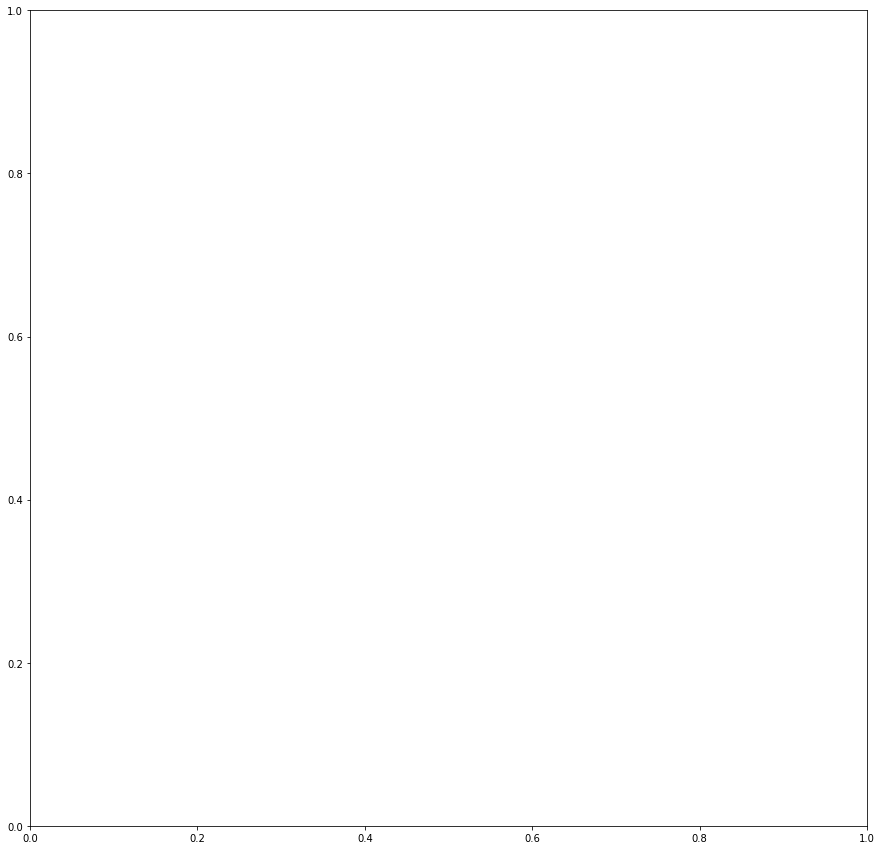

In [ ]:
f, ax = plt.subplots(figsize = (15,15))
grid = sb.FacetGrid(melt_cov_data_chr1, col = 'Tissue', row = 'Assay', margin_titles=True, hue = 'Rep')
grid.map(sb.barplot, 'Start','value')
[plt.setp(ax.texts, text="") for ax in grid.axes.flat]
grid.set_titles(row_template = '{row_name}', col_template = '{col_name}')